In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window

In [2]:
# Inicializar Spark
spark = SparkSession.builder \
    .appName("COVID19Analysis") \
    .getOrCreate()

24/08/13 08:08:30 WARN Utils: Your hostname, Michaels-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.0.11 instead (on interface en0)
24/08/13 08:08:30 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/08/13 08:08:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# Se estiver usando Spark localmente, ajuste o caminho do arquivo
dir_path = "/Users/michaelsantos/Documents/NT-teste/data"
file_path = f"{dir_path}/processed/covid_data_20240813.parquet"
df = spark.read.parquet(file_path)

In [4]:
# Registrar o DataFrame como uma view temporária para consultas SQL
df.createOrReplaceTempView("covid_data")

24/08/13 08:08:39 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


24/08/13 08:08:42 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


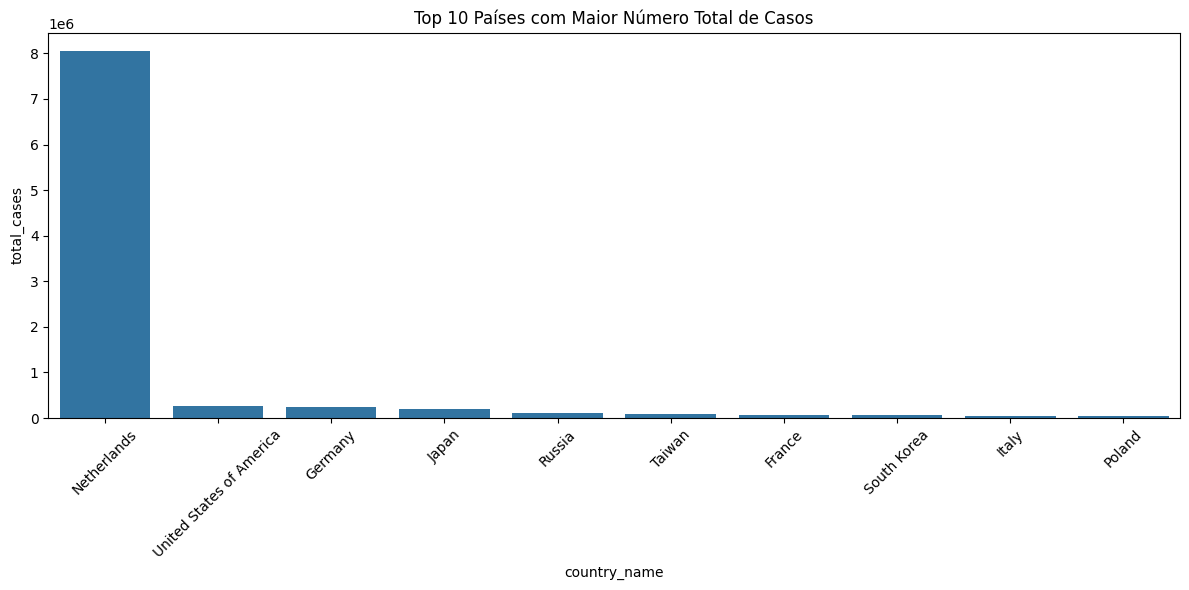

In [5]:
# Análise 1: Países com maior número total de casos
top_countries_cases = spark.sql("""
    SELECT country_name, SUM(new_confirmed) as total_cases
    FROM covid_data
    GROUP BY country_name
    ORDER BY total_cases DESC
    LIMIT 10
""")

# Converter para Pandas para visualização
top_countries_cases_pd = top_countries_cases.toPandas()

plt.figure(figsize=(12, 6))
sns.barplot(x='country_name', y='total_cases', data=top_countries_cases_pd)
plt.title('Top 10 Países com Maior Número Total de Casos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

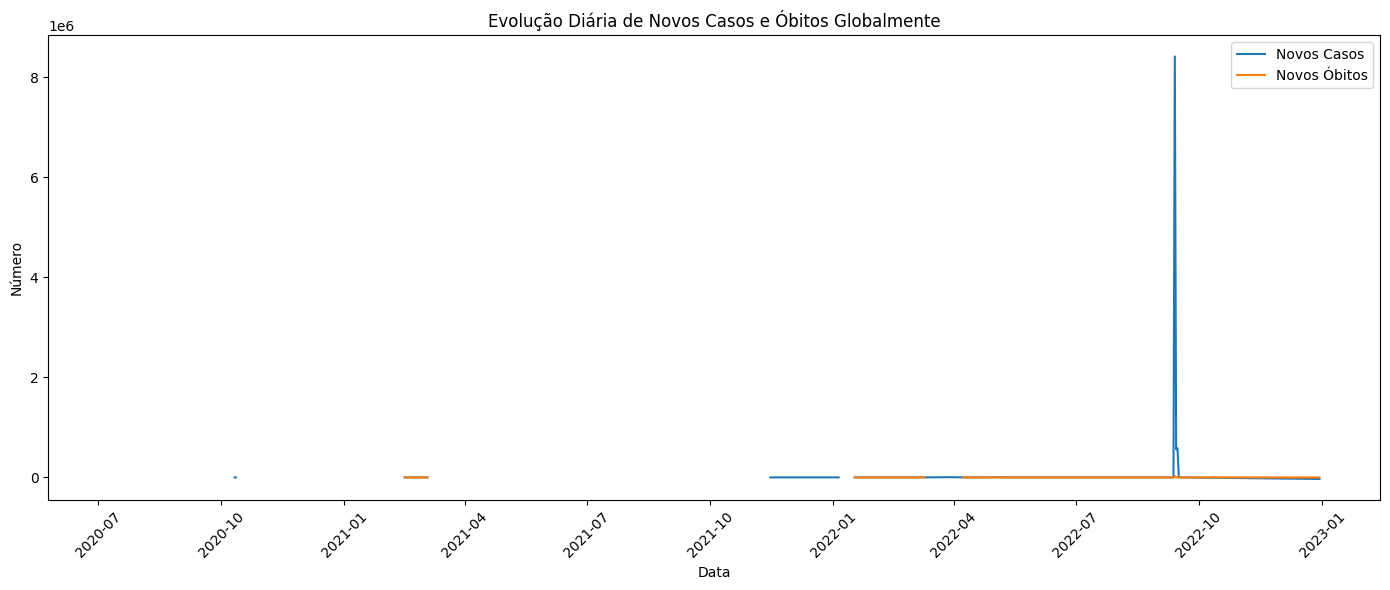

In [6]:
# Análise 2: Evolução diária de novos casos e óbitos globalmente
daily_global = spark.sql("""
    SELECT date, 
           SUM(new_confirmed) as global_new_cases,
           SUM(new_deceased) as global_new_deaths
    FROM covid_data
    GROUP BY date
    ORDER BY date
""")

daily_global_pd = daily_global.toPandas()

plt.figure(figsize=(14, 6))
plt.plot(daily_global_pd['date'], daily_global_pd['global_new_cases'], label='Novos Casos')
plt.plot(daily_global_pd['date'], daily_global_pd['global_new_deaths'], label='Novos Óbitos')
plt.title('Evolução Diária de Novos Casos e Óbitos Globalmente')
plt.xlabel('Data')
plt.ylabel('Número')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

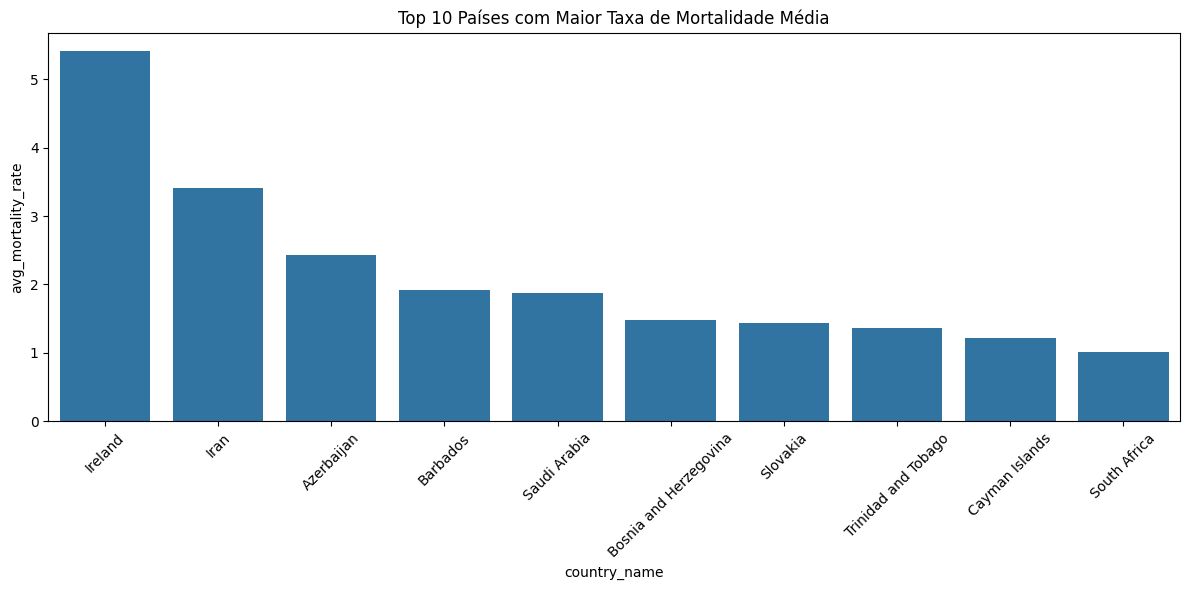

In [7]:
# Análise 3: Taxa de mortalidade média por país
mortality_rate = spark.sql("""
    SELECT country_name, AVG(mortality_rate) as avg_mortality_rate
    FROM covid_data
    GROUP BY country_name
    ORDER BY avg_mortality_rate DESC
    LIMIT 10
""")

mortality_rate_pd = mortality_rate.toPandas()

plt.figure(figsize=(12, 6))
sns.barplot(x='country_name', y='avg_mortality_rate', data=mortality_rate_pd)
plt.title('Top 10 Países com Maior Taxa de Mortalidade Média')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

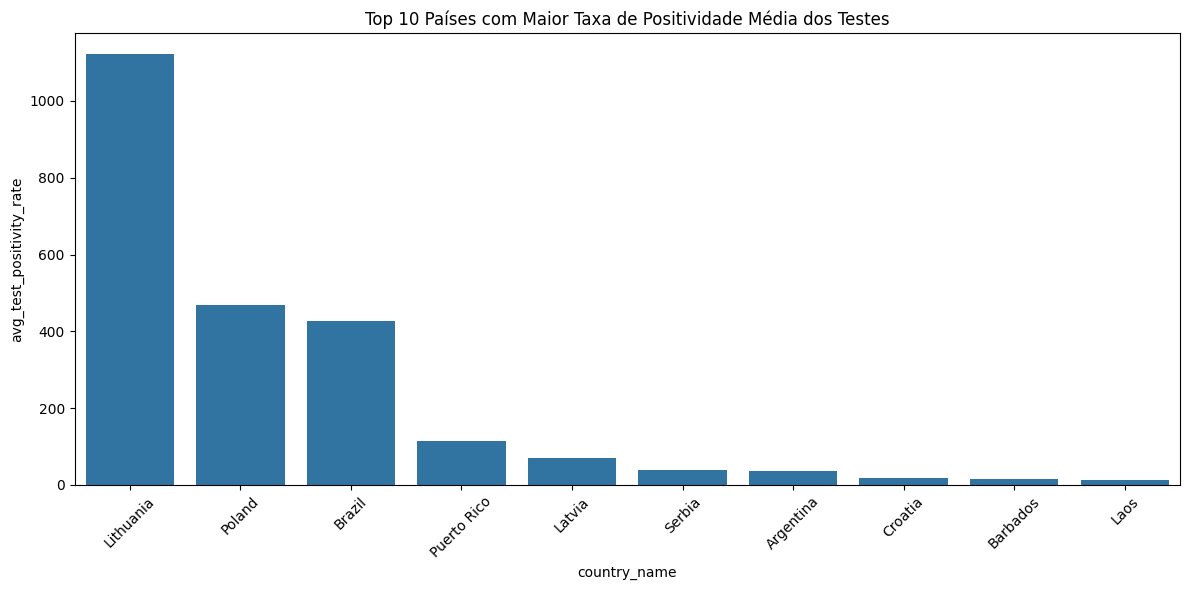

In [8]:
# Análise 4: Taxa de positividade dos testes por país
test_positivity = spark.sql("""
    SELECT country_name, AVG(test_positivity_rate) as avg_test_positivity_rate
    FROM covid_data
    GROUP BY country_name
    ORDER BY avg_test_positivity_rate DESC
    LIMIT 10
""")

test_positivity_pd = test_positivity.toPandas()

plt.figure(figsize=(12, 6))
sns.barplot(x='country_name', y='avg_test_positivity_rate', data=test_positivity_pd)
plt.title('Top 10 Países com Maior Taxa de Positividade Média dos Testes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [9]:
# Análise 5: Correlação entre mobilidade e novos casos
mobility_columns = [col for col in df.columns if col.startswith("mobility_")]
correlation_df = df.select(["new_confirmed"] + mobility_columns)

for col in mobility_columns:
    correlation = correlation_df.stat.corr("new_confirmed", col)
    print(f"Correlação entre novos casos e {col}: {correlation}")

Correlação entre novos casos e mobility_retail_and_recreation: 0.0048777551990027345
Correlação entre novos casos e mobility_grocery_and_pharmacy: 0.00782449384736721
Correlação entre novos casos e mobility_parks: 0.04329914118196677
Correlação entre novos casos e mobility_transit_stations: 0.0037388062504445656
Correlação entre novos casos e mobility_workplaces: 0.004325083364154266
Correlação entre novos casos e mobility_residential: -0.011669460445583247


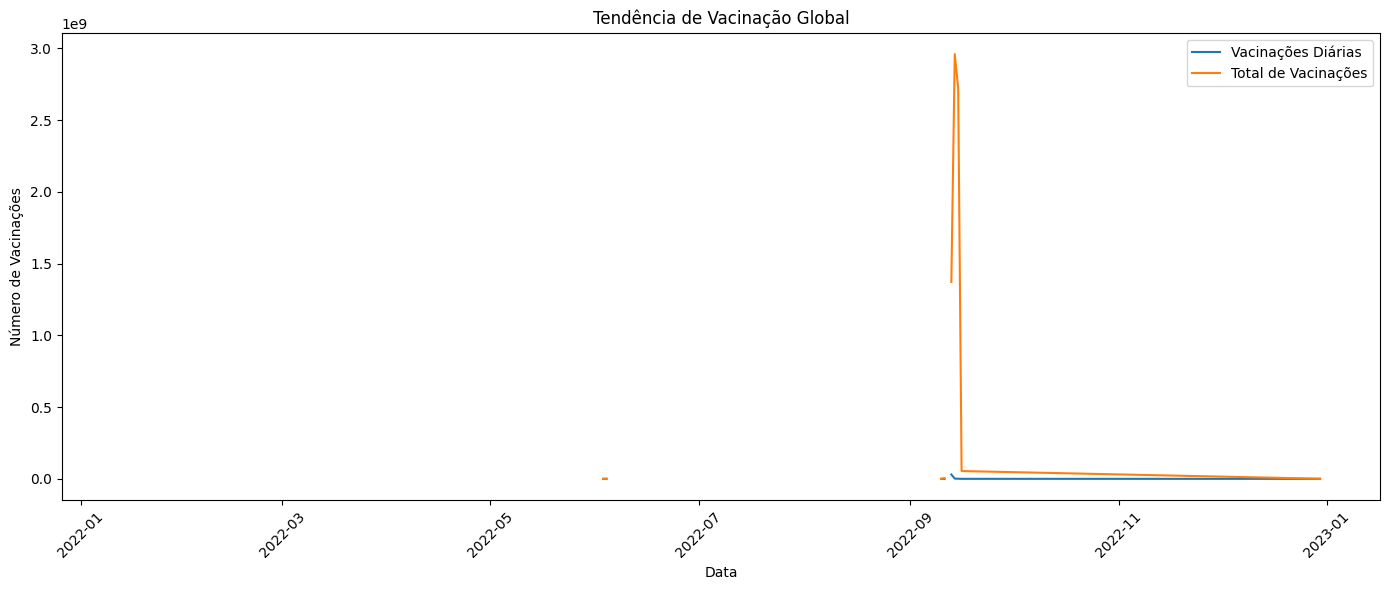

In [10]:
# Análise 6: Tendência de vacinação
vaccination_trend = spark.sql("""
    SELECT date, 
           SUM(new_persons_vaccinated) as daily_vaccinations,
           SUM(cumulative_persons_vaccinated) as total_vaccinations
    FROM covid_data
    GROUP BY date
    ORDER BY date
""")

vaccination_trend_pd = vaccination_trend.toPandas()

plt.figure(figsize=(14, 6))
plt.plot(vaccination_trend_pd['date'], vaccination_trend_pd['daily_vaccinations'], label='Vacinações Diárias')
plt.plot(vaccination_trend_pd['date'], vaccination_trend_pd['total_vaccinations'], label='Total de Vacinações')
plt.title('Tendência de Vacinação Global')
plt.xlabel('Data')
plt.ylabel('Número de Vacinações')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [11]:
# Encerrar a sessão Spark
spark.stop()